# Projeto 1 - Ciência dos Dados

Nome: Arthur Martins de Souza Barreto

Nome: Giselle Vieira de Melo

Atenção: Serão permitidos grupos de três pessoas, mas com uma rubrica mais exigente. Grupos deste tamanho precisarão fazer um questionário de avaliação de trabalho em equipe

___

Os gênios do crime que dominaram as telas do mundo inteiro em <em><b> La casa de Papel </b></em>  e que conquistaram várias premiações como o Emmy Internacional de melhor série dramática, além de se tornar uma das séries mais populares da IMDb possui uma boa aclamação crítica dado seu enredo sofisticado e dramas interpessoais, se tornando a série em língua não inglesa mais assistida de 2018. 

A partir disso, com o lançamento da primeira parte da quinta (e última) temporada no dia 03 de Setembro de 2021, é de regular tendência pelo mundo inteiro comentários no twitter, tendo até celebridades comentando sobre a série nessa rede. 

<center> <img src="imagens/Money-Heist.jpg" width=500> <center> 

Dessa forma, por meio da categorização dos postagens dos usuários do twitter, esse projeto visa analisar os comentários a respeito da obra, como elogios e críticas diretamente relacionados à série, desconsiderando por exemplo, tweets de marcação ou sobre temas paralelos. 

Para tanto, o <em><b>Classificador Naive Bayes </b></em> foi utilizado!

___
Carregando algumas bibliotecas:

In [60]:
# a biblioteca dos emojis precisa ser baixada, caso não tenha baixado descomente a linha a baixo e faça o dowload
#!pip install emoji 
# a biblioteca para a impressão de dados estatisticos precisa ser instalada, descomente caso não tenha instalada 
#!pip install seaborn

In [61]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

In [62]:
# bibliotecas adicionais
import re 
# para eliminar as preposições usei o link a seguir como referencia
# https://stackoverflow.com/questions/29523254/python-remove-stop-words-from-pandas-dataframe
import nltk 
# apra eliminar os emojis usei o seguinte link como referencia
# https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python
import emoji

# funções auxiliares para separar o emoji
import functools
import operator

# função aux para plot da matriz de porcentagem
import seaborn as sn

In [63]:
print('Esperamos trabalhar no diretório')
print(os.getcwd())

Esperamos trabalhar no diretório
C:\Users\arthu\Desktop\Documentos\Insper\2º_Periodo\Ciencia_dos_dados\twitter


Carregando a base de dados com os tweets classificados como relevantes e não relevantes:

In [64]:
filename = 'La casa de papel.xlsx'

In [65]:
train = pd.read_excel(filename)
train.head(5)

,Treinamento,Relevante
0,coisas q serão proibidas quando eu for preside...,1
1,agr que tô terminando de assistir la casa de p...,1
2,paguem minha terapia (la casa de papel vc me p...,0
3,to com pena de terminar la casa de papel,0
4,"olha, quem me segue aqui sabe o tanto que odei...",1


In [66]:
test = pd.read_excel(filename, sheet_name = 'Teste')
test.head(5)

,Teste,Relevante
0,vou assistir a última temperada de la casa de ...,1
1,só quero chegar em casa e me entupir de brigad...,1
2,"toda vez, a gnt depois que acaba de ver la cas...",0
3,@esteseverino na verdade eles se comunicavam p...,1
4,não tô chorando horrores com o final de la cas...,0


___
## Classificador automático de sentimento

Nessa parte inicial do projeto é necessário categorizar a opinião daqueles comentários no twitter relativos à aprovação da série, (mais precisamente da nova temporada).

Assim, foram encontrados diversos tweets, sendo alguns destes demasiadamente vagos, onde não dava para discernir se era um comentário aprovando ou não da série La casa de papel. Nesse caso, foi considerado relevante apenas os comentários que deixavam claro a critica à série. 

- Funções utilizadas!

In [67]:
# FUNÇÕES AUXILIARES DO SISTEMA para a montagem da base de dados do treinamento
def cleanup(text):
    """
        Função de limpeza muito simples que troca alguns sinais básicos por espaços
    """
    #import string
    punctuation = '[!-.:?;\/)|,''""“”@#(*]' # Note que os sinais [] são delimitadores de um conjunto.
    pattern = re.compile(punctuation)
    text_subbed = re.sub(pattern, '', text)
    return text_subbed.lower()

# função baseada no seguinte link: # https://stackoverflow.com/questions/49921720/how-to-split-emoji-from-each-other-python
def separa_emoji(string):
    em_split_emoji = emoji.get_emoji_regexp().split(string)
    em_split_whitespace = [substr.split() for substr in em_split_emoji]
    em_split = functools.reduce(operator.concat, em_split_whitespace)
    return em_split

# baixando as preposições
nltk.download('stopwords')
# definindo as preposições da lingua portuguesa
stop = nltk.corpus.stopwords.words('portuguese')

def segunda_limpeza(lis_tweet):
    limpo = []
    for pal in lis_tweet:
        # além de verificar se a palavra não é uma preposição vamos pegar só as que tem mais de 3 letras
        # vamos aproveitar que estamos percorrendo cada palavra e separar os emojis nesse processo
        if pal not in stop:
            aux = separa_emoji(pal)
            for info in aux:
                limpo.append(info)
        else:
            pass
    return limpo

def frase_para_palavras(df):
    '''
    função para percorrer linha a linha uma coluna do dataframe e concatenar as palavras em uma unica lista
    para ser usada no value_counts()
    '''
    data = ''
    
    for tweet in df:
        # o tweet é a frase que a pessoa postou, que se encontra em cada linha da nossa coluna
        titulo = 'la casa de papel'
        titulo_new = 'lacasadepapel'
        if titulo in tweet:
            tweet = tweet.replace(titulo,titulo_new)
        data += tweet
        
    # dando o split agora, para separar por virgula
    data = data.split()
    # data é um vetor, podemos chamar a função de tirar preposição aqui
    data = segunda_limpeza(data)
    return data

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\arthu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


___


## Montando um Classificador Naive-Bayes

Considerando apenas as mensagens da planilha Treinamento, ensine  seu classificador.

O classificador Naive-Bayes é da família de classificadores estatísticos baseado no Teorema de Bayes, sendo utilizado para prever a ocorrência em um texto, muito útil para esse trabalho já que estamos tratando uma sequência de tweets sobre o tema em questão "La casa de papel". 

Assim, esse classificador, ao ter um conhecimento prévio das condições - aqui dadas por relevante (1) e irrelevante (0) -  utiliza da frequência de palavras para fazer sua classificação, já que ele trata cada palavra de uma frase como um termo independente, como por exemplo: "la casa de papel é muito bom" é equivalente a "é muito bom la casa de papel".

### O teorema de Bayes e as probabilidades independentes:
"Os eventos A e B são independentes quando o fato de ter conhecimento sobre a ocorrência de A não altera a expectativa sobre a probabilidade de ocorrência do evento B."

Isso é muito útil para o nosso modelo já que a probabilidade de que as mesmas frases sejam ditas em postagens distintas no twitter é baixa, mas ao fazer a suposição de que cada palavra em uma frase atua de forma independente é possível se realizar os cálculos de probabilidade.

### Cálculos de probabilidade

- legenda:

    - $P(rel)$: probabilidade do post ser relevante;

    - $P(irrel)$: probabilidade do post ser irrelevante;

    - $P(total)$: $P(rel)$ + $P(irrel)$

    - $P(rel|total)$: 
    $$P(rel|total) = \frac{P(total|rel) P(rel)}{P(total)}$$
    
    - $P(irrel|total)$: 
    $$P(irrel|total) = \frac{P(total|irrel) P(irrel)}{P(total)}$$

#### Suavização de Laplace
Pelo cálculo das probabilidades independentes tem-se que, dado uma palavra, descobrir qual é a probabilidade de essa palavra está na base de dados a partir de sua frequência. Agora imagine que a palavra não está na base de dados... o que ocorre é que a probabilidade é zero, e ao realizar a multiplicação dos termos, o cálculo é anulado, não gerando nenhuma informação (o contrário do que se espera).

Assim, a suavização de Laplace surge para prevenir esse caso, dado que é adicionado 1 a cada contagem, para que o denominador nunca fique nulo. Em contrapartida, é também adicionado o número de palavras totais ao divisor, o que leva a, ao realizar a divisão, gerar sempre um número menor que um. 





#### Apresentado o medelo, vamos implementar agora no código! 

In [68]:
#convertendo em variáveis categóricas:
train['Treinamento'] = train['Treinamento'].astype('category')
test['Teste'] = test['Teste'].astype('category')

In [69]:
#limpando pontuações do dataframe
train['Clean']=train['Treinamento'].apply(cleanup)
test['Clean']=test['Teste'].apply(cleanup)

In [70]:
test

,Teste,Relevante,Clean
0,vou assistir a última temperada de la casa de ...,1,vou assistir a última temperada de la casa de ...
1,só quero chegar em casa e me entupir de brigad...,1,só quero chegar em casa e me entupir de brigad...
2,"toda vez, a gnt depois que acaba de ver la cas...",0,toda vez a gnt depois que acaba de ver la casa...
3,@esteseverino na verdade eles se comunicavam p...,1,esteseverino na verdade eles se comunicavam pe...
4,não tô chorando horrores com o final de la cas...,0,não tô chorando horrores com o final de la cas...
...,...,...,...
195,acabei la casa de papel,0,acabei la casa de papel
196,precisamos conversar sobre o final dessa tempo...,0,precisamos conversar sobre o final dessa tempo...
197,"eu odeio lá casa de papel, mataram a tóquio va...",1,eu odeio lá casa de papel mataram a tóquio vai...
198,preguiça de ver essa parte 5 de la casa de papel,0,preguiça de ver essa parte 5 de la casa de papel


In [71]:
# post relevante
post_rel = train.loc[(train['Relevante'] == 1)]
# post irrelevante
post_irrel = train.loc[(train['Relevante'] == 0)]

In [72]:
# agora precisamos quebrar o texto em palavras, usando a função aux que converter frase em palavras,
# ao mesmo tempo, vamos retirar as preposições do código, paralelamente a conversão, melhorando a base de dados, temos:
data_rel   = frase_para_palavras(post_rel['Clean'])
data_irrel = frase_para_palavras(post_irrel['Clean'])

# criando a serie dos posts relevantes e irrelevantes
serie_rel = pd.Series(data_rel)
serie_irrel = pd.Series(data_irrel)
# Formando uma base de daddos com todas as palavras nele:
data_total = data_rel + data_irrel

#criando a serie com a base total de dados
serie_total = pd.Series(data_total)

print(len(serie_rel))
print(len(serie_irrel))
print(len(serie_total))
serie_irrel.tail(20)

1368
1087
2455


1067        trabalhar
1068               🤦🏾
1069               🤦🏾
1070           recebi
1071          spoiler
1072    lacasadepapel
1073            quero
1074          cometer
1075     homicídiovou
1076       aproveitar
1077              pra
1078              ver
1079            novos
1080        episódios
1081               lá
1082             casa
1083            papel
1084       abafadinha
1085               🙏🏼
1086                ✨
dtype: object

#### Frequências absolutas

Palavras em um texto são variáveis **qualitativas nominais**, portanto usaremos `value_counts()` para obter a tabela de frequências relativas e absolutas:

In [73]:
# construindo a tabela de relevante e irrelevante
tabela_rel   = serie_rel.value_counts()
tabela_irrel = serie_irrel.value_counts()
tabela_total = serie_total.value_counts()
lista_serie_total = serie_total.tolist()
elementos_nao_repetidos = set(lista_serie_total)
elementos_nao_repetidos = pd.DataFrame(elementos_nao_repetidos).value_counts()
elementos_nao_repetidos

100             1
parte           1
parâmetro       1
participação    1
partetô         1
               ..
fez             1
fica            1
ficar           1
ficaram         1
🥺               1
Length: 1143, dtype: int64

___
### Verificando a performance do Classificador

Agora você deve testar o seu classificador com a base de Testes.

In [74]:
# postagens relevantes
post_rel.head()

,Treinamento,Relevante,Clean
0,coisas q serão proibidas quando eu for preside...,1,coisas q serão proibidas quando eu for preside...
1,agr que tô terminando de assistir la casa de p...,1,agr que tô terminando de assistir la casa de p...
4,"olha, quem me segue aqui sabe o tanto que odei...",1,olha quem me segue aqui sabe o tanto que odeio...
6,que final fdp do lá casa de papel,1,que final fdp do lá casa de papel
8,"final veio de lá casa de papel, meu pai amado ...",1,final veio de lá casa de papel meu pai amado o...


In [75]:
# postagens irrelevantes
post_irrel.head()

,Treinamento,Relevante,Clean
2,paguem minha terapia (la casa de papel vc me p...,0,paguem minha terapia la casa de papel vc me paga
3,to com pena de terminar la casa de papel,0,to com pena de terminar la casa de papel
5,simplesmente devastada com esse final da 1° pa...,0,simplesmente devastada com esse final da 1° pa...
7,ai la casa de papel me mata pqp,0,ai la casa de papel me mata pqp
10,criadores de lá casa de papel deixaram mto na ...,0,criadores de lá casa de papel deixaram mto na ...


In [76]:
p_rel = len(serie_rel)/len(serie_total)
print('A probabilidade de relevantes é: {0:.3f}'.format(p_rel))

A probabilidade de relevantes é: 0.557


In [77]:
p_irrel = len(serie_irrel)/len(serie_total)
print('A probabilidade de irrelevate é: {0:.3f}'.format(p_irrel))

A probabilidade de irrelevate é: 0.443


### Funções auxiliares para a suavização de la place

In [78]:
def quantas_vezes_aparece_palavra(palavra,tabela):
    # a função retorna o valor de vezes que a palavra aparece no seu conjunto
    # por exemplo, quantas vezes aparece na tabela relevante?
    # fazemos: num = tabela_rel['palavra']
    # e retornamos esse valor
    # por outro lado, pode não ter a palavra, por isso a suaviação de la place, quando isso ocorrer,
    # vamos retornar 0
    try:
        # caso em que a palavra tem na tabela de frequencias
        quant = tabela[palavra]
        return quant
    except:
        # aqui a palavra não está na tabela de frequencias,retornamos 0
        return 0
    
def laplace_smoothing(palavras_da_classe,quantidade):
    # vamos aplicar a formula da suavização
    num = quantidade + 1
    den = len(palavras_da_classe) + len(elementos_nao_repetidos)
    #den = 2193 + len(elementos_nao_repetidos)
    laplace = num/den
    return laplace

def p_tweet(tweet,relevante):
    # se relevante for true, calcula para relevante
    # se for false, para irrelevante
    p = 1
    # quebrando o tweet a cada espaço 
    tweet_em_palavras = tweet.split()
    
    for palavra in tweet_em_palavras:
        # vamos calcular o valor da frequencia absoluta da palavra
        # para isto, usaremos a funcao quantas_vezes_aparece_palavra
        # verificando qual classe queremos calcular p
        
        if relevante:
            quant = quantas_vezes_aparece_palavra(palavra,tabela_rel)
            p_palavra = laplace_smoothing(serie_rel,quant)
            
        else:
            quant = quantas_vezes_aparece_palavra(palavra,tabela_irrel)
            p_palavra = laplace_smoothing(serie_irrel,quant)
            
        p *= p_palavra
    return p

def rel_ou_irrel(tweet):
    # vamos decidir se o tweet é relevante ou não
    # para tal vamos aplicar o teorema de bayes
    P_tweet_rel   = p_tweet(tweet,True)
    P_tweet_irrel = p_tweet(tweet,False)
    rel_bayes     = P_tweet_rel*p_rel
    irrel_bayes   = P_tweet_irrel*p_irrel
    #print(rel_bayes,irrel_bayes)
    # vamos usar o mesmo criterio adotado na tabela, 1 para relevante e 0 para irrelevante
    if rel_bayes > irrel_bayes:
        return 1
    else:
        return 0

In [79]:
# agora vamos criar uma coluna nova, com a classificação dos tweets
train['Classificação'] = train['Clean'].apply(rel_ou_irrel)
train

,Treinamento,Relevante,Clean,Classificação
0,coisas q serão proibidas quando eu for preside...,1,coisas q serão proibidas quando eu for preside...,1
1,agr que tô terminando de assistir la casa de p...,1,agr que tô terminando de assistir la casa de p...,1
2,paguem minha terapia (la casa de papel vc me p...,0,paguem minha terapia la casa de papel vc me paga,0
3,to com pena de terminar la casa de papel,0,to com pena de terminar la casa de papel,0
4,"olha, quem me segue aqui sabe o tanto que odei...",1,olha quem me segue aqui sabe o tanto que odeio...,1
...,...,...,...,...
295,mó sacanagem esse final de la casa de papel,1,mó sacanagem esse final de la casa de papel,1
296,recebi spoiler de la casa de papel e quero com...,0,recebi spoiler de la casa de papel e quero com...,0
297,terminei la casa de papel e me tornei o homem ...,1,terminei la casa de papel e me tornei o homem ...,1
298,vou aproveitar pra ver os novos episódios de l...,0,vou aproveitar pra ver os novos episódios de l...,0


In [80]:
test['Classificação'] = test['Clean'].apply(rel_ou_irrel)
test

,Teste,Relevante,Clean,Classificação
0,vou assistir a última temperada de la casa de ...,1,vou assistir a última temperada de la casa de ...,1
1,só quero chegar em casa e me entupir de brigad...,1,só quero chegar em casa e me entupir de brigad...,0
2,"toda vez, a gnt depois que acaba de ver la cas...",0,toda vez a gnt depois que acaba de ver la casa...,0
3,@esteseverino na verdade eles se comunicavam p...,1,esteseverino na verdade eles se comunicavam pe...,0
4,não tô chorando horrores com o final de la cas...,0,não tô chorando horrores com o final de la cas...,1
...,...,...,...,...
195,acabei la casa de papel,0,acabei la casa de papel,1
196,precisamos conversar sobre o final dessa tempo...,0,precisamos conversar sobre o final dessa tempo...,1
197,"eu odeio lá casa de papel, mataram a tóquio va...",1,eu odeio lá casa de papel mataram a tóquio vai...,1
198,preguiça de ver essa parte 5 de la casa de papel,0,preguiça de ver essa parte 5 de la casa de papel,0


In [81]:
# verdadeiro_negativo = test.loc[(test['Relevante']==0)&(test['Classificação']==0),:].shape[0]
# verdadeiro_positivo = test.loc[(test['Relevante']==1)&(test['Classificação']==1),:].shape[0]
# acuracia = (verdadeiro_positivo + verdadeiro_negativo)/test.shape[0]
# print('A acuracia do classificador na base de teste foi de {:.2f} %'.format(acuracia*100))

<AxesSubplot:title={'center':'Matriz de Confusão na Base Treino \n informações em porcentagem\n'}, xlabel='Classificação', ylabel='Relevante'>

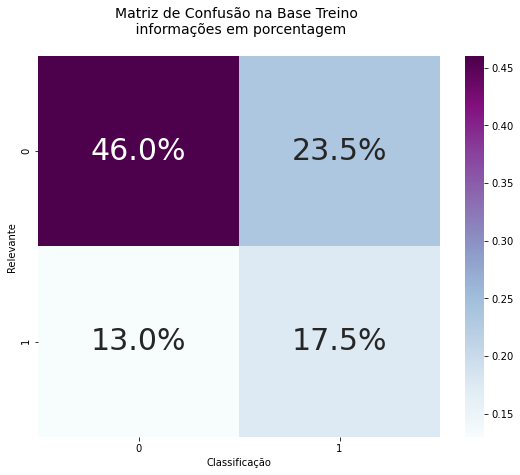

In [82]:
# analizando a classificaçao como um todo, e poltando um grafico, temos:
df_cm=pd.crosstab(test.Relevante,test.Classificação,normalize=True)
plt.figure(figsize = (9,7))
plt.title('Matriz de Confusão na Base Treino \n informações em porcentagem\n',fontdict={'fontsize': 14})
sn.heatmap(df_cm, annot=True, annot_kws={"size":30},fmt='.1%',cmap="BuPu")

Deste modo, temos: 
14   % de falso positivo
16,5 % de verdadeiro positivo
23   % de falso negativo
46,5 % de verdadeiro negativo

In [24]:
#porcentagem de verdadeiros negativos:
relevante = test.loc[test['Relevante']==0]
classificacao_rel = relevante.loc[relevante['Classificação']==0]
#print('total de verdadeiros negativos:{0}'.format(len(classificacao_rel)))
print('A porcentagem de verdadeiros negativos: {:.4}%'.format( ((len(classificacao_rel))/len(test['Relevante'])*100)))

A porcentagem de verdadeiros negativos: 46.0%


In [25]:
#porcentagem de verdadeiros positivos:
irrelevante = test.loc[test['Relevante']==1]
classificacao_irrel = irrelevante.loc[irrelevante['Classificação']==1]

print('A porcentagem de verdadeiros positivos: {:.4}%'.format( ((len(classificacao_irrel))/len(test['Relevante'])*100)))

A porcentagem de verdadeiros positivos: 17.5%


In [26]:
#porcentagem de falsos negativos:
relevante = test.loc[test['Relevante']==1]
classificacao_irrel = relevante.loc[relevante['Classificação']==0]
print('A porcentagem de falsos negativos é: {:.4}%'.format(((len(classificacao_irrel))/len(test['Relevante'])*100)))

A porcentagem de falsos negativos é: 13.0%


In [27]:
#porcentagem de falsos positivo:
irrelevante = test.loc[test['Relevante']==0]
classificacao_rel = irrelevante.loc[irrelevante['Classificação']==1]
print('a porcentagem de falsos positivos é: {:.4}%'.format( ((len(classificacao_rel))/len(test['Relevante'])*100)))

a porcentagem de falsos positivos é: 23.5%


In [28]:
#acurácia
total_irrel = len(test.loc[(test['Relevante']==0)&(test['Classificação']==0)])
total_rel = len(test.loc[(test['Relevante']==1)&(test['Classificação']==1)])

total = total_rel + total_irrel
acuracia = total/len(test['Relevante'])
acuracia *= 100
print('A acurácia é: {:.4} % '.format(acuracia))


A acurácia é: 63.5 % 


___
### Concluindo

___
### Qualidade do Classificador a partir de novas separações dos tweets entre Treinamento e Teste

Caso for fazer esse item do Projeto

In [29]:
# vamos juntar as duas tabelas em uma tabela só
test_novo = pd.read_excel(filename, sheet_name = 'Teste')
test_novo = test_novo.rename(columns={'Teste':'Total'})

train_novo = pd.read_excel(filename, sheet_name = 'Treinamento')
train_novo = train_novo.rename(columns={'Treinamento':'Total'})

# juntando as duas tabelas
data_total_ = pd.concat([train_novo,test_novo])
# limpando a pontuação
# a limpeza mais profunda ocorrerá quando transfprmamos os tweets em palavras, neste passo, iremos limpar, separar emojis, tudo
# paralelamente
data_total_['Clean'] = data_total_['Total'].apply(cleanup)
data_total_
type(data_total_)
# agora devemos aplicar a rotina de limpeza novamente

pandas.core.frame.DataFrame

In [51]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
# vamos usar a biblioteca sklearn.model_selection.train_test_split, com código de exemplo obtido no link acima

from sklearn.model_selection import train_test_split
# vamos guardar os verdadeiros positivos, verdadeiros negativos e a acuracia de cada rodagem em um vetor para analiza grafica futura
true_positive = []
true_negative = []
acurracy      = []

# queremos repetir pelo menos 100 vezes, para repetir n vezes coloque no segundo argumento no range n-1
for i in range(0,10000):
    #print(type(data_total))
    X_train, X_test, y_train, y_test = train_test_split(data_total_[['Clean','Relevante']],data_total_['Relevante'], test_size=0.4)
    # teste size é a proporção da base de dados para teste. Como queremos 200/500, teste sieze será 0.4
    #print('amigo estou aq')
    # separando o treinamento relevante do irrelevante
    train_relevantes   = X_train[X_train['Relevante'] == 1]
    train_irrelevantes = X_train[X_train['Relevante'] == 0]
    
    # agora vamos quebrar o texto em palavras, e fazer a segunda limpeza nos dados, desde considerar 'la casa de papel'
    # como 'lacasadepapel' a separar os emojis. A FUNÇÃO FRASE_PARA_PALAVRAS fara a limpeza citada
    
    data_rel   = frase_para_palavras(train_relevantes['Clean'])
    data_irrel = frase_para_palavras(train_irrelevantes['Clean'])
    
    # Formando uma base de daddos com todas as palavras nele:
    data_total = data_rel + data_irrel
    
    # criando a serie dos posts relevantes e irrelevantes
    serie_rel = pd.Series(data_rel)
    serie_irrel = pd.Series(data_irrel)
    #criando a serie com a base total de dados
    serie_total = pd.Series(data_total)
    
    # criando tabela de frequencia das palavras, seram usadas para calcular a frequencia absoluta na suavização de laplace
    tabela_rel   = serie_rel.value_counts()
    tabela_irrel = serie_irrel.value_counts()
    tabela_total = serie_total.value_counts()
    # vamos calcular os elementos não repetidos, necessário na suavização de laplace
    lista_serie_total = serie_total.tolist()
    elementos_nao_repetidos = set(lista_serie_total)
    elementos_nao_repetidos = pd.DataFrame(elementos_nao_repetidos).value_counts()
    
    # definindo a probabilidade de ser relevante e a probabilidade de ser irrelevante
    p_rel = len(serie_rel)/len(serie_total)
    p_irrel = len(serie_irrel)/len(serie_total)
    
    # neste momento vamos classificar a base de teste
    X_test['Classificação'] = X_test['Clean'].apply(rel_ou_irrel)
    
    # agora vamos calular porcentagem dos verdadeiros positivos, verdadeiros negativos e a acuracia do sistema
    verdadeiro_positivo=X_test.loc[(X_test['Classificação']==1)&(X_test['Relevante']==1),:].shape[0]
    verdadeiro_negativo=X_test.loc[(X_test['Classificação']==0)&(X_test['Relevante']==0),:].shape[0]
    acuracia=(verdadeiro_positivo+verdadeiro_negativo)/X_test.shape[0]
    
    # calculando as porcentagens:
    P_ver_pos = (verdadeiro_positivo/X_test.shape[0])*100
    P_ver_neg = (verdadeiro_negativo/X_test.shape[0])*100
    acuracia *= 100
    
    # guardando os verdadeiros positivos, negativos e a acuraria no vetor vazia criando antes do laço de repetição
    true_positive.append(P_ver_pos)
    true_negative.append(P_ver_neg)
    acurracy.append(acuracia)    

In [52]:
print(max(acurracy))
print(min(acurracy))
print(max(true_positive))
print(min(true_positive))
print(max(true_negative))
print(min(true_negative))

73.5
48.0
49.5
4.0
56.49999999999999
7.5


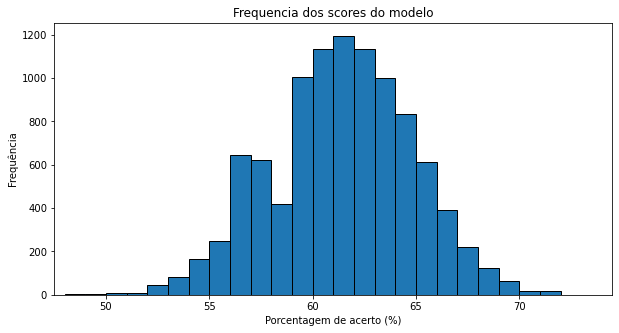

In [57]:
faixa=np.arange(47,75,1)
plt.figure(figsize=(10, 5))
plt.hist(acurracy, bins=faixa, edgecolor='black', density=False)
plt.title('Frequencia dos scores do modelo')
plt.ylabel('Frequência')
plt.xlabel('Porcentagem de acerto (%)')
plt.xlim(47.5,74.5)
plt.show()

___
## Aperfeiçoamento:

Trabalhos que conseguirem pelo menos conceito B vão evoluir em conceito dependendo da quantidade de itens avançados:

* IMPLEMENTOU outras limpezas e transformações que não afetem a qualidade da informação contida nos tweets. Ex: stemming, lemmatization, stopwords
* CORRIGIU separação de espaços entre palavras e emojis ou entre emojis e emojis
* CRIOU categorias intermediárias de relevância baseadas na probabilidade: ex.: muito relevante, relevante, neutro, irrelevante, muito irrelevante. Pelo menos quatro categorias, com adição de mais tweets na base, conforme enunciado. (OBRIGATÓRIO PARA TRIOS, sem contar como item avançado)
* EXPLICOU porquê não pode usar o próprio classificador para gerar mais amostras de treinamento
* PROPÔS diferentes cenários para Naïve Bayes fora do contexto do projeto
* SUGERIU e EXPLICOU melhorias reais com indicações concretas de como implementar (indicar como fazer e indicar material de pesquisa)
* FEZ o item 6. Qualidade do Classificador a partir de novas separações dos tweets entre Treinamento e Teste descrito no enunciado do projeto (OBRIGATÓRIO para conceitos A ou A+)

___
## Referências

[Naive Bayes and Text Classification](https://arxiv.org/pdf/1410.5329.pdf)  **Mais completo**

[A practical explanation of a Naive Bayes Classifier](https://monkeylearn.com/blog/practical-explanation-naive-bayes-classifier/) **Mais simples**